In [4]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-09-18T11:56:54+02:00

CPython 3.6.1
IPython 5.3.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.10.0-33-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


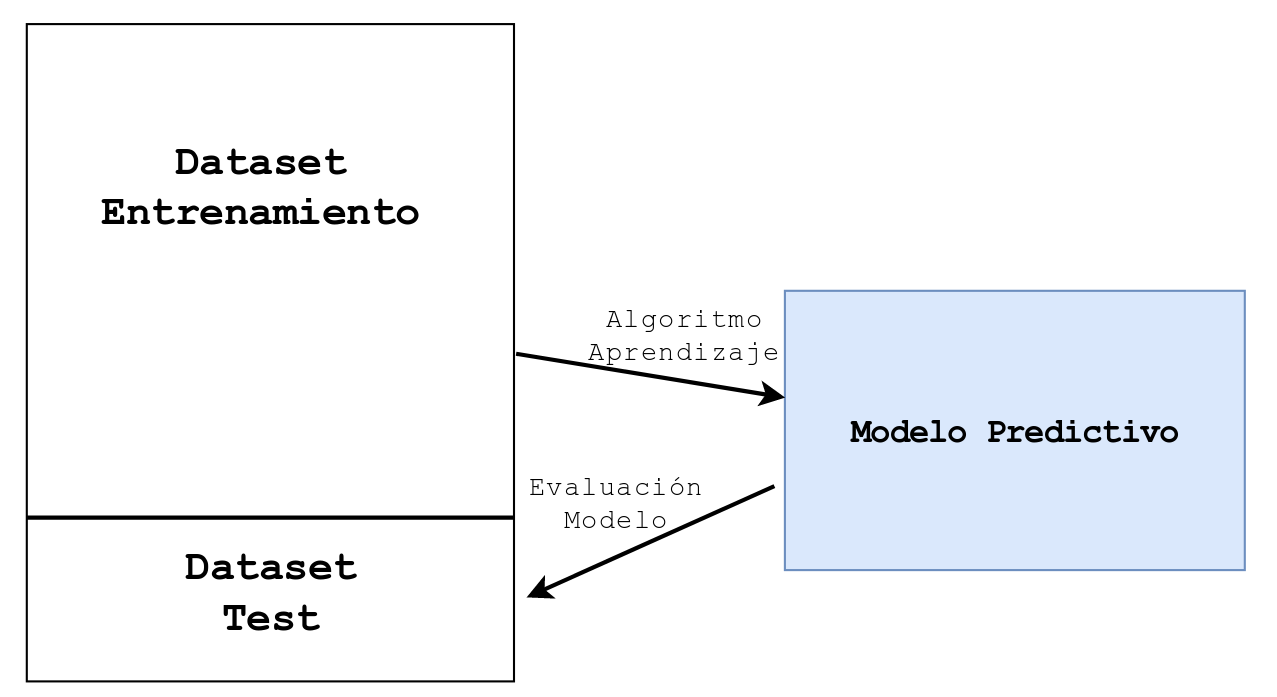

In [5]:
from IPython.display import Image

Image("../../media/train_test_split.jpg")

In [6]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import datasets

In [7]:
boston = datasets.load_boston()

In [8]:
def rmse(objetivo, estimaciones):
    return np.sqrt(metrics.mean_squared_error(objetivo, estimaciones)
                  )

def adjusted_r2(objetivo, estimaciones, n, k):
    r2 = metrics.r2_score(objetivo, estimaciones)
    return 1 - (1-r2)*(n-1) / (n - k - 1)

def evaluar_modelo(objetivo, estimaciones, n, k):
    return {
        "rmse": rmse(objetivo, estimaciones),
        "mae": metrics.mean_absolute_error(objetivo, estimaciones),
        "adjusted_r2": adjusted_r2(objetivo, estimaciones, n, k)
           }

In [9]:
modelo_ols = LinearRegression()

modelo_ols.fit(X=boston["data"], y=boston["target"])

modelo_ols_preds = modelo_ols.predict(boston["data"])

In [10]:
RESULTADOS = {}

In [11]:
N = boston["data"].shape[0]

RESULTADOS["ols"] = evaluar_modelo(
    boston["target"],
    modelo_ols_preds,
    N,
    len(modelo_ols.coef_)
)

RESULTADOS

{'ols': {'adjusted_r2': 0.73375388241218709,
  'mae': 3.2729446379969378,
  'rmse': 4.6795063006355164}}

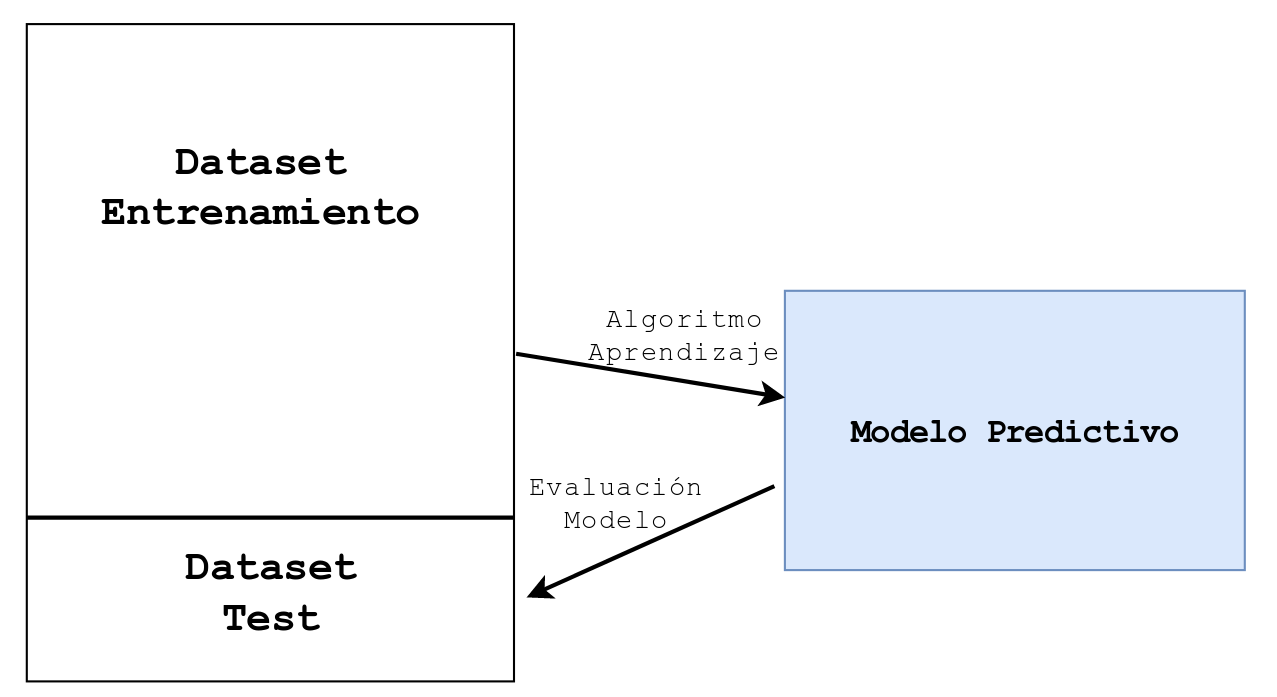

In [12]:
from IPython.display import Image

Image("../../media/train_test_split.jpg")

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_test_split?

In [15]:
boston["data"].shape

(506, 13)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
     boston["data"], boston["target"],
     test_size=0.33, random_state=13
)

In [17]:
print(X_train.shape, y_train.shape)

(339, 13) (339,)


In [18]:
print(X_test.shape, y_test.shape)

(167, 13) (167,)


In [19]:
modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)

In [20]:
RESULTADOS["ols_train"] = evaluar_modelo(
    y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

In [21]:
modelo_ols_test_preds = modelo_ols.predict(X_test)

RESULTADOS["ols_test"] = evaluar_modelo(
    y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

In [22]:
import pandas as pd

In [23]:
pd.DataFrame(RESULTADOS)

,ols,ols_test,ols_train
adjusted_r2,0.733754,0.688345,0.731491
mae,3.272945,3.568149,3.300868
rmse,4.679506,4.787026,4.721732


Vemos que al separar los datos de entrenamiento y los de test se obtiene un resultado peor al evaluar los datos de test.

Podríamos parar aquí y decir *"El error RMSE de mi modelo es 4.787026"*, y podríamos pensar que esta todo bien ya que no hemos entrenado el modelo en los datos que hemos usado para evaluarlo.

Pero estaríamos en un grave error. ¿Por qué? 

Recordad que hemos usado un `random_state=13` para la función `train_test_split` que garantiza que la separación de entrenamiento y test sea siempre la misma. Podemos usar cualquier número para este argumento.

Qué pasa si usamos por ejemplo `random_state=42`?

In [24]:
RESULTADOS = {}

X_train, X_test, y_train, y_test = train_test_split(
     boston["data"], boston["target"],
     test_size=0.33, random_state=42
)


modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)
modelo_ols_test_preds = modelo_ols.predict(X_test)


RESULTADOS["ols_train"] = evaluar_modelo(
    y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

RESULTADOS["ols_test"] = evaluar_modelo(
    y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

pd.DataFrame(RESULTADOS)

,ols_test,ols_train
adjusted_r2,0.702558,0.728822
mae,3.151288,3.374888
rmse,4.554903,4.794110


¡El error en los datos de test es menor que en los de entrenamiento! ¿Por qué? Sencillamente, por que ha dado la casualidad de que hemos separado los datos de una forma que los datos de test son muy fáciles de estimar.

Para ver la magnitud del error en el que estamos cayendo al hacer una sola separación entre test y entrenamiento, vamos a probar un monton de semillas y ver cual es el rango del error que se puede obtener 

In [25]:
model=LinearRegression()
results = []
def test_seed(seed):
    X_train, X_test, y_train, y_test = train_test_split(
     boston["data"], boston["target"],
     test_size=0.33, random_state=seed
    )
    test_preds = model.fit(X_train, y_train).predict(X_test)
    seed_rmse = rmse(y_test, test_preds)
    results.append([seed_rmse, seed])

In [26]:
for i in range(1000):
    test_seed(i)

In [27]:
results[:5]

[[5.1527667114047553, 0],
 [4.5486961982507212, 1],
 [4.8191161224653554, 2],
 [4.8236098315350331, 3],
 [5.5606186915805074, 4]]

In [28]:
results_sorted = sorted(results, key=lambda x: x[0], reverse=False)

In [29]:
results_sorted[0]

[3.6315202809340414, 635]

In [30]:
results_sorted[-1]

[6.7888736504655398, 645]

**Validación Cruzada (Cross Validation)**

Vemos que entre la semilla con menor error de test y la semilla con mayor error hay una diferencia casi del doble!

Una forma de evitar el cometer este error es mediante la **Validación cruzada**

![cross_val](https://cdn-images-1.medium.com/max/1600/1*J2B_bcbd1-s1kpWOu_FZrg.png)

In [31]:
from sklearn.model_selection import cross_val_score

In [32]:
cross_val_score?

In [33]:
modelo_ols = LinearRegression()
X = boston["data"]
y = boston["target"]

resultados_validación_cruzada = cross_val_score(
    estimator=modelo_ols, 
    X=X,
    y=y,
    scoring="neg_mean_squared_error", 
    cv=10
)

In [34]:
resultados_validación_cruzada

array([  -9.30130569,  -14.17208374,  -14.10631149,  -35.19479431,
        -31.92474931,  -19.85853694,   -9.95792   , -168.53075207,
        -33.61791833,  -10.96654317])

In [35]:
resultados_validación_cruzada.mean()

-34.763091505422409

In [36]:
def rmse_cross_val(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(metrics.mean_squared_error(y, y_pred))

In [37]:
resultados_cv = []
for i in range(10,200):
    cv_rmse = cross_val_score(
        estimator=modelo_ols, 
        X=X,
        y=y,
        scoring=rmse_cross_val, 
        cv=i
    ).mean()
    resultados_cv.append(cv_rmse)

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

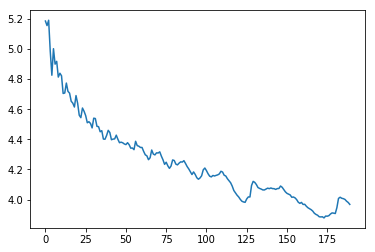

In [39]:
plt.plot(resultados_cv)

In [44]:
from sklearn.model_selection import cross_validate
scoring = {"mae": "neg_mean_absolute_error", "rmse": rmse_cross_val}
estimator = modelo_ols
scores = cross_validate(estimator, boston["data"],
                        boston["target"], scoring=scoring,
                         cv=100, return_train_score=True)

In [45]:
pd.DataFrame(scores).mean()

fit_time      0.000645
score_time    0.000293
test_mae     -3.513620
test_rmse     4.185483
train_mae    -3.272699
train_rmse    4.677286
dtype: float64